# Simulation_CLP_PID_FF

### Simulation of a PID in closed loop with feed forward option

In [29]:
import tclab
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
from datetime import datetime
import os
from importlib import reload

import package_DBR
from package_DBR import myRound, SelectPath_RT, FO_RT, Delay_RT

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, IMC_Tuning
package_LAB = reload(package_LAB)

## Simulation parameters

In [30]:
TExp = 1200
Ts = 1
N = int(TExp/Ts) + 1

# Working points
MV0 = 50
DV0 = 50
PV0 = 52.16    #To determine experimentally (set MV and DV at 50% and read stabilized PV value) -> use TCLab_OLP.ipynb

# Input/output simulation parameters
Kp = 0.5310660848084217
T1p = 186.994025442462
T2p = 2.9068218394939005e-05
thetap = 2.999961859860621

# Disturbance simulation parameters
Kd = 0.6100735687252915
T1d = 260.50316881553425
T2d = 10.615160143180168
thetad = 1.1476745182375387

# PID parameters
gamma = 0.5
Kc, Ti, Td = IMC_Tuning(Kp,T1p,T2p,thetap,gamma)
print("Kc = {}, Ti = {}, Td = {}".format(Kc,Ti,Td))

Kc = 3.648930014515632, Ti = 186.9940545106804, Td = 2.9068213876285602e-05


## Simulation scenarios

In [31]:
scenario = 4

if scenario == 1:
#1 MAN + no FF
    TExp = 500
    title = "Response with manual controller (without feedforward)"
    man_modePath = {0 : True, TExp : True}
    MVManPath = {0 : MV0+45, 80 : MV0, TExp : MV0}
    SPPath = {0 : PV0, TExp : PV0}
    DVPath = {0 : 50, 200: 70, TExp : 70}
    FF_Active = False

elif scenario == 2:
#2 MAN + FF
    TExp = 500
    title = "Response with manual controller and feedforward"
    man_modePath = {0 : True, TExp : True}
    MVManPath = {0 : MV0+45, 80 : MV0, TExp : MV0}
    SPPath = {0 : PV0, TExp : PV0}
    DVPath = {0 : 50, 200: 70, TExp : 70}
    FF_Active = True

elif scenario == 3:
#3 CLP + no FF
    TExp = 1200
    title = "Closed-loop response with PID controller (without feedforward)"
    man_modePath = {0 : True, 100: False, TExp : False}
    MVManPath = {0 : MV0+45, 80 : MV0, TExp : MV0}
    SPPath = {0 : PV0, 225 : PV0 + 5, 425 : PV0 - 10, TExp : PV0 - 10}
    DVPath = {0 : DV0, 900 : DV0 + 15, TExp : DV0 + 15}
    FF_Active = False

elif scenario == 4:
#4 CLP + FF
    TExp = 1200
    title = "Closed-loop response with PID controller and feedforward"
    man_modePath = {0 : True, 100: False, TExp : False}
    MVManPath = {0 : MV0+45, 80: MV0, TExp : MV0}
    SPPath = {0 : PV0, 225 : PV0 + 5, 425 : PV0 - 10, TExp : PV0 - 10}
    DVPath = {0 : DV0, 900 : DV0 + 15, TExp : DV0 + 15}
    FF_Active = True

Ts = 1
N = int(TExp/Ts) + 1

## Simulation variables

In [32]:
t = []
SP = []
E = []
MV = []
MVP = []
MVI = []
MVD = []
MVFF = []
man_mode = []
MVMan = []
MVmin = 0
MVmax = 100
DV = []
PV = []
alpha = 0.5

# for FF
MVFFDelay = []
MVFFLL1 = []

In [33]:
# lab.close()

## Experiment

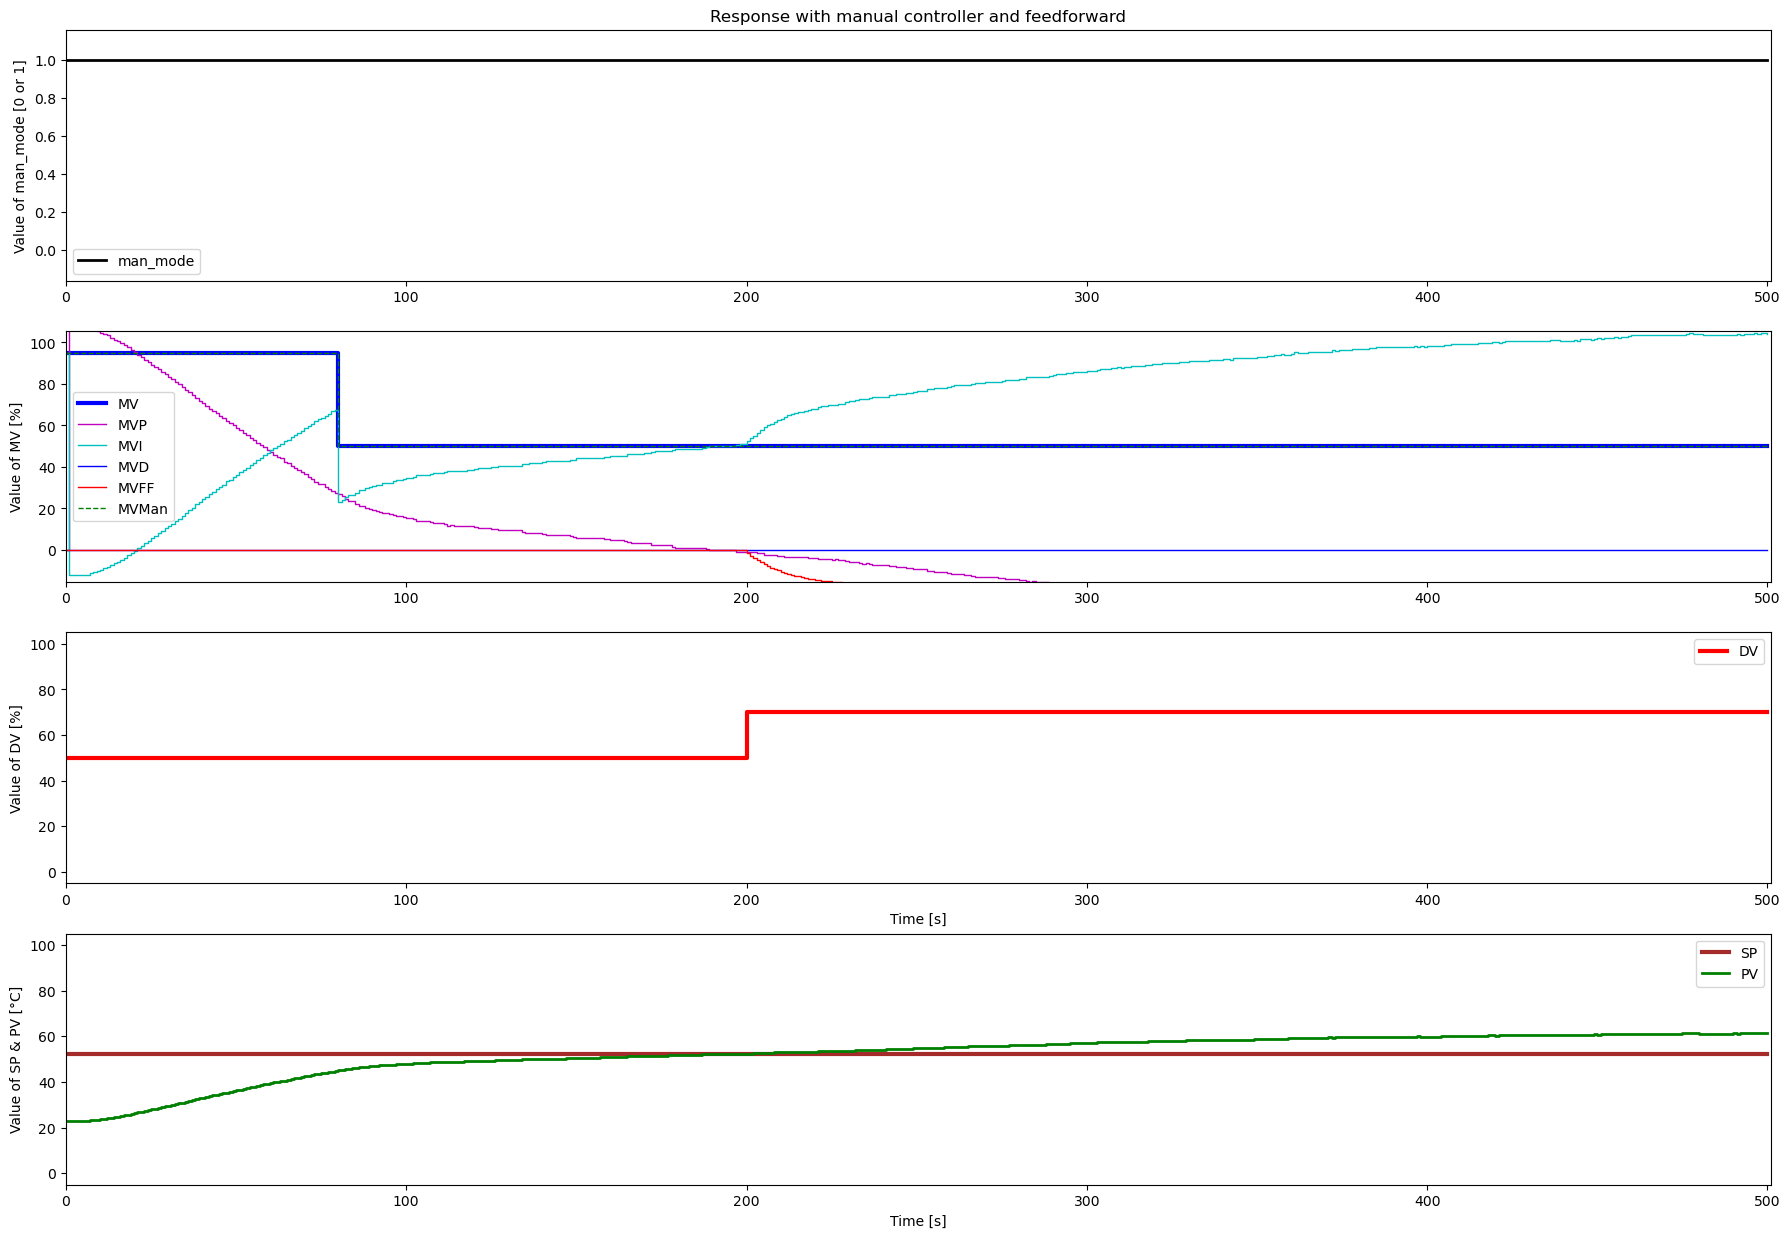

TCLab disconnected successfully.


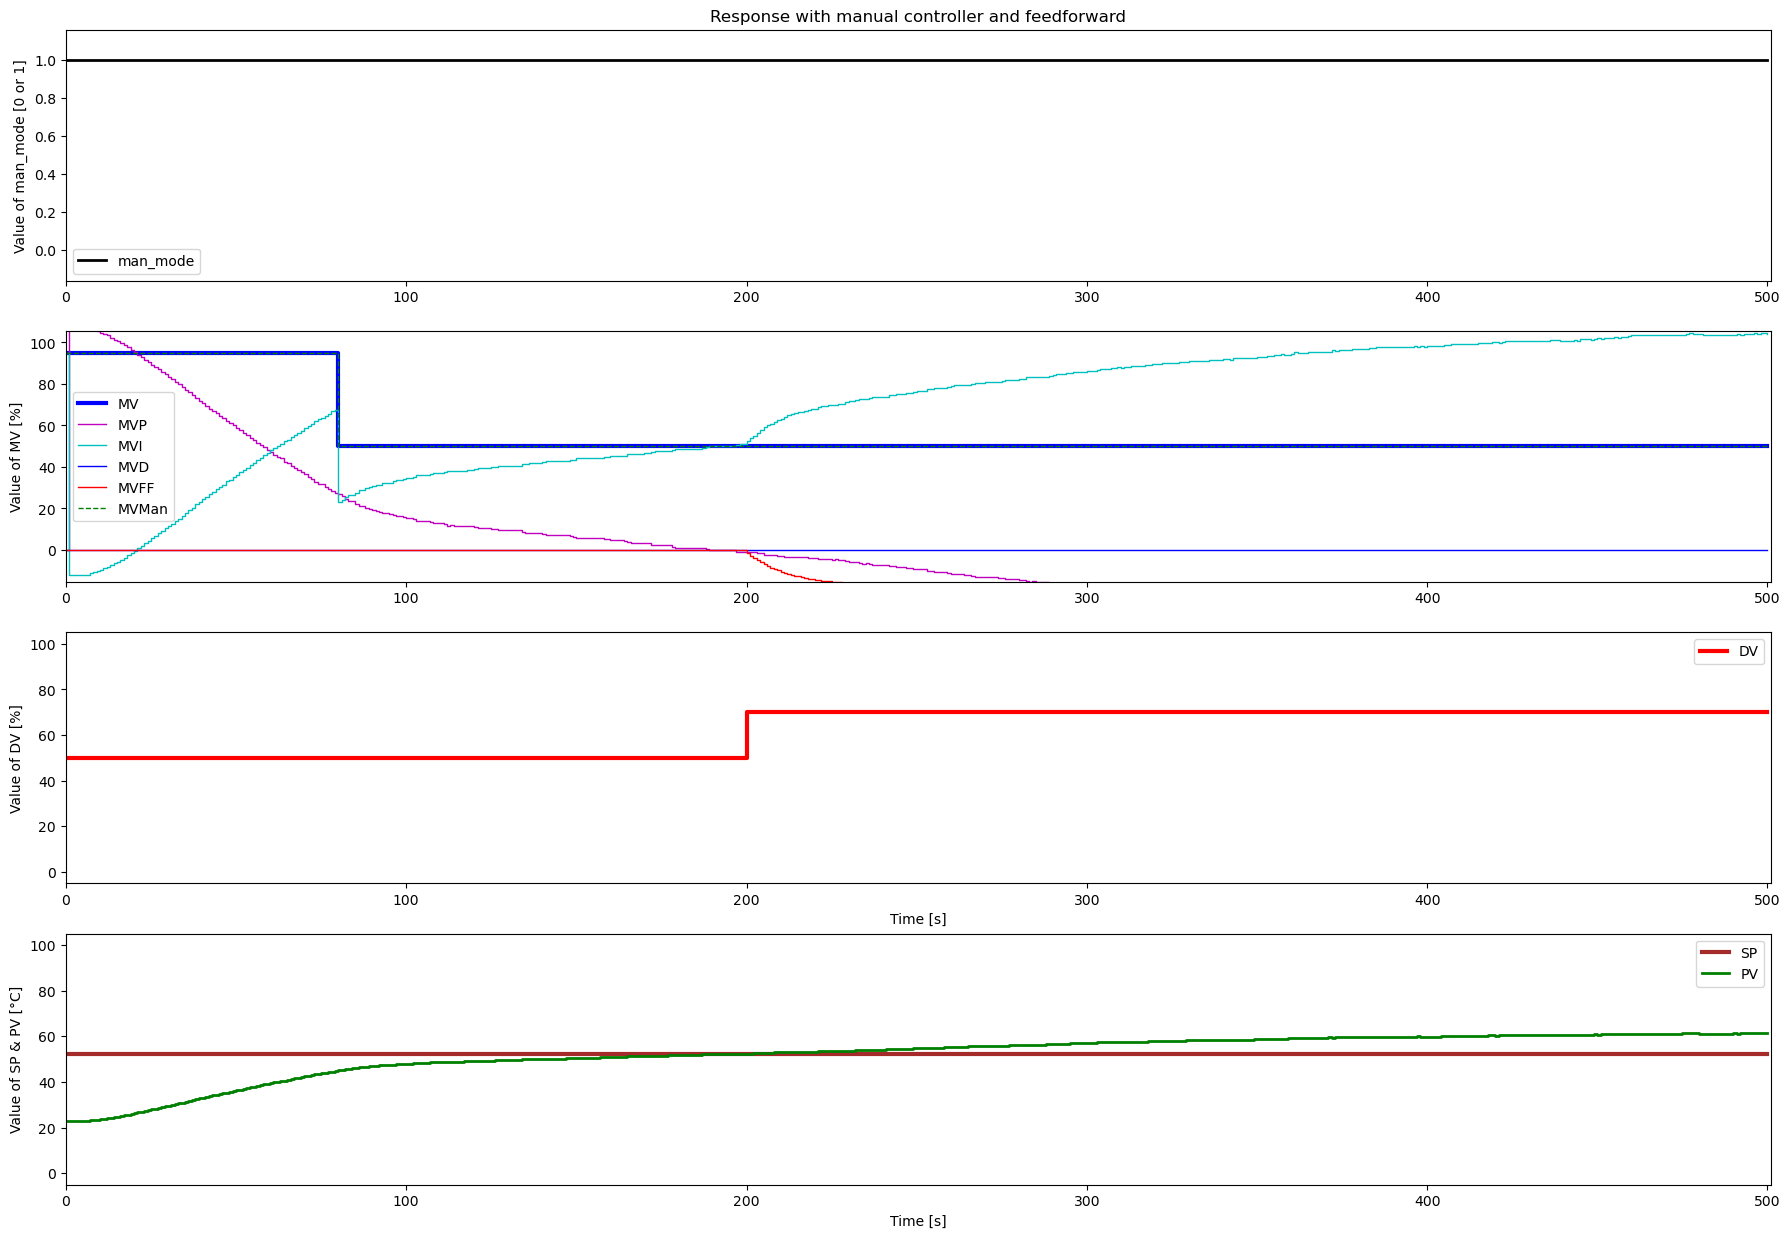

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(15)
fig.set_figwidth(22)

l1, = ax1.step([0,TExp],[-0.1,1.1],'k-',linewidth=2,label='man_mode',where='post')
ax1.set_ylabel('Value of man_mode [0 or 1]')
ax1.set_title(title)
ax1.legend(loc='best')

l2, = ax2.step([0,TExp],[-10,100],'b-',linewidth=3,label='MV',where='post')
l3, = ax2.step([0,TExp],[-10,100],'m-',linewidth=1,label='MVP',where='post')
l4, = ax2.step([0,TExp],[-10,100],'c-',linewidth=1,label='MVI',where='post')
l5, = ax2.step([0,TExp],[-10,100],'b-',linewidth=1,label='MVD',where='post')
l6, = ax2.step([0,TExp],[-10,100],'r-',linewidth=1,label='MVFF',where='post')
l7, = ax2.step([0,TExp],[-10,100],'g--',linewidth=1,label='MVMan',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l8, = ax3.step([0,TExp],[0,100],'r-',linewidth=3,label='DV',where='post')
ax3.set_ylabel('Value of DV [%]')
ax3.set_xlabel('Time [s]')
ax3.legend(loc='best')

l9, = ax4.step([0,TExp],[0,100],'brown',linewidth=3,label='SP',where='post')
l10, = ax4.step([0,TExp],[0,100],'g-',linewidth=2,label='PV',where='post')
ax4.set_ylabel('Value of SP & PV [°C]')
ax4.set_xlabel('Time [s]')
ax4.legend(loc='best')

lab = tclab.TCLab()

for i in range(0,N):
    t.append(i*Ts)

    # Setpoint and Disturbance value
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath, t, DV)

    # Feedforward
    Delay_RT(DV - DV0 * np.ones_like(DV), np.max([thetad - thetap, 0]), Ts, MVFFDelay)
    LeadLag_RT(MVFFDelay, -Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    if FF_Active:
        LeadLag_RT(MVFFLL1, 1, T2p, T2d, Ts, MVFF)
    else:
        LeadLag_RT(MVFFLL1, 0, T2p, T2d, Ts, MVFF)

    # manual data
    SelectPath_RT(man_modePath, t, man_mode)
    SelectPath_RT(MVManPath, t, MVMan)

    # PID
    PID_RT(SP, E, MV, MVP, MVI, MVD, MVFF, man_mode, MVMan, MVmin, MVmax, PV, Ts, Kc ,Ti, Td, alpha)

    # MV
    lab.Q1(MV[-1])
    lab.Q2(DV[-1])

    time.sleep(Ts)

    PV.append(lab.T1)

    ##### RT PLOT #####
    clear_output(wait=True)  

    l1.set_data(t,man_mode)
    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)
    l6.set_data(t,MVFF)
    l7.set_data(t,MVMan)
    l8.set_data(t,DV)
    l9.set_data(t,SP)
    l10.set_data(t,PV)

    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)

    display(fig)

lab.close()

# Save data in text file
# ----------------------
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
# Conversion to array
t = np.array(t)
man_mode = np.array(man_mode)
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
MVFF = np.array(MVFF)
MVMan = np.array(MVMan)
DV = np.array(DV)
SP = np.array(SP)
PV = np.array(PV)
my_data = np.vstack((t.T, man_mode.T, MV.T, MVP.T, MVI.T, MVD.T, MVFF.T, MVMan.T, DV.T, SP.T, PV.T))
my_data = my_data.T
nameFile = 'Data/PID_scenario_{}_'.format(scenario) + date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,man_mode,MV,MVP,MVI,MVD,MVFF,MVMan,DV,SP,PV',comments='')        


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

titleName = 'PID_scenario_{}_'.format(scenario) + date_time
plt.savefig('Plots\\' + titleName + '.png',transparent=True)
plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)

## plots

(0.0, 500.0)

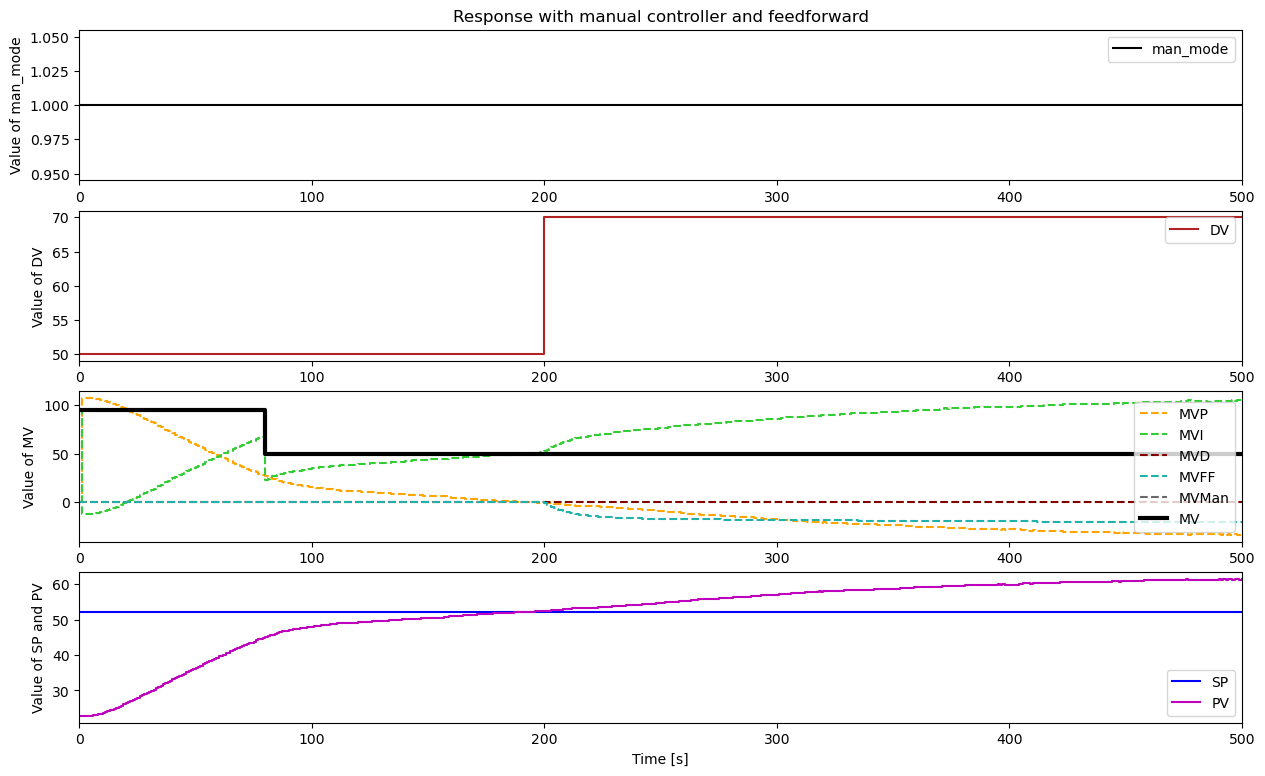

In [35]:
plt.figure(figsize = (15,9))

plt.subplot(4,1,1)
plt.title(title)
plt.step(t,man_mode,'black',label='man_mode',where='post')
plt.ylabel('Value of man_mode')
plt.legend(loc='best')
plt.xlim([0, TExp])

plt.subplot(4,1,2)
plt.step(t,DV,'firebrick',label='DV',where='post')
plt.ylabel('Value of DV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TExp])

plt.subplot(4,1,3)
plt.step(t,MVP,'orange',linestyle='dashed',label='MVP',where='post')
plt.step(t,MVI,'limegreen',linestyle='dashed',label='MVI',where='post')
plt.step(t,MVD,'maroon',linestyle='dashed',label='MVD',where='post')
plt.step(t,MVFF,'lightseagreen',linestyle='dashed',label='MVFF',where='post')
plt.step(t,MVMan,'dimgrey',linestyle='dashed',label='MVMan',where='post')
plt.step(t,MV,'black',linewidth=3,label='MV',where='post')
plt.ylabel('Value of MV')
plt.legend(loc='best')
plt.xlim([0, TExp])

plt.subplot(4,1,4)
plt.step(t,SP,'b-',label='SP',where='post')
plt.step(t,PV,'m-',label='PV',where='post')
plt.ylabel('Value of SP and PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TExp])